Goal is to detect three types of rhyming techniques: 
- assonance.
- mutli-syllable rhymes.
- rhyming schemes. 

- Read data: 
Read the lyrics in a list of lines. 
- preprocessing steps: 
1. remove special characters. 
2. remove maningless words? (implement it but keep it open). 
3. create a vowel representation for each word (assonance detection)
4. create a syllable representation of each word (multis detection)

In [1]:
import pronouncing
import nltk
from nltk.corpus import stopwords
from rhyme_analytics import *
from wordcloud import WordCloud
from matplotlib import pyplot as plt
import pandas as pd

# Read & Preprocess Data

Lyrics of each song will be broken down to list of lines. For each line, extra spaces and special characters will be removed. For each line, a list of words will be generated. 

In [2]:
diss_tracks = pd.read_csv('diss_tracks.csv')

In [3]:
diss_tracks.count()

Date Released    144
Song Title       144
Artist(s)        144
Target(s)        144
Year Released    144
lyrics            69
dtype: int64

In [4]:
diss_tracks_cleaned = diss_tracks.dropna(subset=['lyrics'])

In [5]:
diss_tracks_cleaned.count()

Date Released    69
Song Title       69
Artist(s)        69
Target(s)        69
Year Released    69
lyrics           69
dtype: int64

In [6]:
print(diss_tracks.columns)

Index(['Date Released', 'Song Title', 'Artist(s)', 'Target(s)',
       'Year Released', 'lyrics'],
      dtype='object')


In [ ]:
new_row = {'Date Released': "January 29, 1845", 'Song Title': "The Raven", 'Artist(s)': "Edgar Allan Poe",
           'Target(s)': "", 'Year Released': "1845", 'lyrics': ""}
## add the Raven poem to our dataframe for analysis
with open('The_Raven.txt', 'r', encoding='utf-8') as file:
    lines = file.read()
new_row["lyrics"] = lines
diss_tracks_cleaned.loc[len(diss_tracks_cleaned)] = new_row

ValueError: cannot set a row with mismatched columns

In [7]:
grouped_df = diss_tracks_cleaned.groupby('Artist(s)').count()

In [8]:
list_artists = grouped_df.index.tolist()
song_frequencies = grouped_df['Date Released'].tolist()/grouped_df['Date Released'].sum()

In [9]:
assert len(list_artists) == len(song_frequencies)

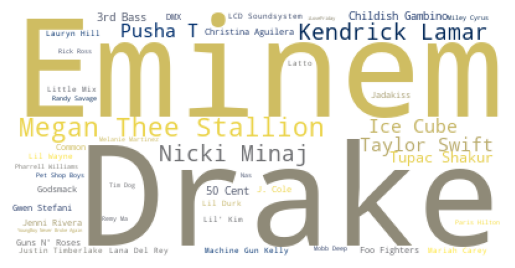

In [10]:
d = {w: f for w, f in
     zip(list_artists, song_frequencies)}
wordcloud = WordCloud(background_color='white', colormap='cividis', prefer_horizontal=1)
wordcloud.generate_from_frequencies(frequencies=d)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


In [11]:
diss_tracks_cleaned['lines'] = ""
diss_tracks_cleaned['words'] = ""

C:\Users\zohabidi\AppData\Local\Temp\ipykernel_32848\4291361658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diss_tracks_cleaned['lines'] = ""
C:\Users\zohabidi\AppData\Local\Temp\ipykernel_32848\4291361658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diss_tracks_cleaned['words'] = ""


In [12]:
for index,row in diss_tracks_cleaned.iterrows():
    if row['lyrics'] is None:
        continue
    lines,words = [], []
    # Iterate over each line in the file
    for line in row['lyrics'].split('\n'):
        if len(line) == 0:
            continue
        line = clean_line(line)
        ## remove stopwords not so sure about it. 
        lines.append(line)
        words.extend(line.split())
        
    diss_tracks_cleaned.at[index,'lines'] = lines
    diss_tracks_cleaned.at[index,'words'] = words

In [13]:
diss_tracks_cleaned.head()

,Date Released,Song Title,Artist(s),Target(s),Year Released,lyrics,lines,words
0,4-Mar-91,"""Fuck Compton""",Tim Dog,"DJ Quik, Michel'le, N.W.A, Compton, West Coast...",1991,Oh shit mutherfuckas step to the rear and chee...,[Oh shit mutherfuckas step to the rear and che...,"[Oh, shit, mutherfuckas, step, to, the, rear, ..."
1,1-May-91,"""Pop Goes the Weasel""",3rd Bass,Vanilla Ice,1991,"Antoine, Antoine's got something here\r\nRo-ro...","[Antoine Antoine's got something here, Ro roll...","[Antoine, Antoine's, got, something, here, Ro,..."
3,17-Sep-91,"""Get in the Ring""",Guns N' Roses,Music critics. Mentioned by name are critics f...,1991,Why do you look at me when you hate me\r\nWhy ...,"[Why do you look at me when you hate me, Why s...","[Why, do, you, look, at, me, when, you, hate, ..."
4,29-Oct-91,"""No Vaseline""",Ice Cube,"former N.W.A bandmates Eazy-E, Dr. Dre, MC Ren...",1991,"Got damn, I'm glad ya'll set it off.\r\nUsed t...","[Got damn I'm glad ya'll set it off, Used to b...","[Got, damn, I'm, glad, ya'll, set, it, off, Us..."
5,9-Dec-91,"""Miserablism""",Pet Shop Boys,Morrissey,1991,It seems to me there's something serious begin...,[It seems to me there's something serious begi...,"[It, seems, to, me, there's, something, seriou..."


In [14]:
len(diss_tracks_cleaned)

69

# Multi Rhyming Syllables

## Phonetic Representation

Rhyming words do not end necessarily with the same letters, their endings are pronounced the same. Syllables are the building blocks of words. To reflect how a word is pronounced, we will refer to the phonetic representation of each syllable. A rhyme is detected when two phonetic representations of two syllables are "very" similar (Their similarity is above a specific threshold).

In [15]:
# example on how to get syllables
word = 'Winter'
syllables = dic.inserted(word).split('-')

print(f"syllables of word {word} are {syllables}")

syllables of word Winter are ['Win', 'ter']


In [16]:
# example on phonetic representation
print(phonetics.metaphone('Win'),phonetics.metaphone('ter'))

AN TR


In [17]:
# the following function given a string returns a tuple of two lists: the first list is the list of syllables
# and the second list is the list of phonetic representation of the syllables. 
create_phonetic_syllable_representation("Cold Winter Day")

(['Cold', 'Win', 'ter', 'Day'], ['KLT', 'AN', 'TR', 'T'])

In [18]:
create_phonetic_syllable_representation("gold winners play")

(['gold', 'win', 'ners', 'play'], ['KLT', 'AN', 'NRS', 'PL'])

The logic behind detecting multi syllable rhymes works as following: 
- for each syllable in the current line, we check all remaining syllables. When we detect a similar syllable we add an extension. The extension means that we start looking into the next syllables after the first match, if they also match. We continue adding matches until we cannot find matching syllables. 
- A multi rhyme is added if it contains two syllables or more. 

In [19]:
_,current_line_syllables_ph=create_phonetic_syllable_representation("Cold Winter Day")
_,next_line_syllables_ph=create_phonetic_syllable_representation("gold winners play")
detect_multi_rhymes(current_line_syllables_ph, next_line_syllables_ph)

[(['KLT', 'AN', 'TR', 'T'], ['KLT', 'AN', 'NRS', 'PL'])]

## Multi Rhyme Score

Writing multi rhymes is an ultimate skill in rapping and difficult to pull off. That's why the more rhyming syllables, a song has, the higher should be the score. Considering the fact that songs have different length, the score will be normalised on the number of song lines. 

In [20]:
# As an example, we will compute the multi rhyme score for the first song. 
lines = diss_tracks_cleaned['lines'][0]
multi_rhymes = detect_song_multi_rhymes(lines) 
compute_multi_rhyme_analytics(multi_rhymes, len(lines))

(32, 2.0, 1.9523809523809523)

In [21]:
diss_tracks_cleaned['multi_rhyme_score'] = 0

C:\Users\zohabidi\AppData\Local\Temp\ipykernel_32848\731128998.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diss_tracks_cleaned['multi_rhyme_score'] = 0


In [22]:
for index, row in diss_tracks_cleaned.iterrows():
    lines = row['lines']
    multi_rhymes = detect_song_multi_rhymes(lines) 
    number_multi_rhymes, average_len_multi_rhymes, multi_rhyme_score = compute_multi_rhyme_analytics(multi_rhymes, len(lines))
    diss_tracks_cleaned.at[index,'multi_rhyme_score'] = multi_rhyme_score

C:\Users\zohabidi\AppData\Local\Temp\ipykernel_32848\2446724148.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.9523809523809523' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  diss_tracks_cleaned.at[index,'multi_rhyme_score'] = multi_rhyme_score


In [23]:
diss_tracks_cleaned.sort_values(by='multi_rhyme_score', ascending=False)

,Date Released,Song Title,Artist(s),Target(s),Year Released,lyrics,lines,words,multi_rhyme_score
106,22-Apr-22,"""Plan B""",Megan Thee Stallion,Tory Lanez,2022,"Who the fuck you think you talkin' to, nigga?\...","[Who the fuck you think you talkin' to nigga, ...","[Who, the, fuck, you, think, you, talkin', to,...",5.450980
103,22-Feb-22,"""AHHH HA""",Lil Durk,YoungBoy Never Broke Again,2022,"Ayy, this shit like videos, you hear me?\r\nEv...","[Ayy this shit like videos you hear me, Everyt...","[Ayy, this, shit, like, videos, you, hear, me,...",5.000000
104,22-Feb-22,"""I Hate YoungBoy""",YoungBoy Never Broke Again,"Lil Durk, India Royale, Gucci Mane, Lil Baby, ...",2022,"Say, 10\r\nLet's hear this shit, Rell (Hah, ha...","[Say 10, Let's hear this shit Rell Hah hah, Ho...","[Say, 10, Let's, hear, this, shit, Rell, Hah, ...",4.866667
5,9-Dec-91,"""Miserablism""",Pet Shop Boys,Morrissey,1991,It seems to me there's something serious begin...,[It seems to me there's something serious begi...,"[It, seems, to, me, there's, something, seriou...",4.513514
116,26-Jan-24,"""Hiss""",Megan Thee Stallion,"Nicki Minaj, Drake, Pardison Fontaine, and Tor...",2024,I just wanna kick this shit off by sayin' fuck...,[I just wanna kick this shit off by sayin' fuc...,"[I, just, wanna, kick, this, shit, off, by, sa...",4.350000
...,...,...,...,...,...,...,...,...,...
15,25-Aug-96,"""Drop a Gem on 'Em""",Mobb Deep,Tupac Shakur,1996,It's the infamous back in the house once again...,[It's the infamous back in the house once agai...,"[It's, the, infamous, back, in, the, house, on...",1.519481
142,14-Jun-24,"""Double Life""",Pharrell Williams,Drake,2024,"Yeah, brraa\r\nYeah\r\nHey, what are you hidin...","[Yeah brraa, Yeah, Hey what are you hiding Wat...","[Yeah, brraa, Yeah, Hey, what, are, you, hidin...",1.465517
70,17-May-15,"""Bad Blood""",Taylor Swift,Katy Perry,2015,Cause baby now we got bad blood\nYou know it u...,"[Cause baby now we got bad blood, You know it ...","[Cause, baby, now, we, got, bad, blood, You, k...",1.375000
3,17-Sep-91,"""Get in the Ring""",Guns N' Roses,Music critics. Mentioned by name are critics f...,1991,Why do you look at me when you hate me\r\nWhy ...,"[Why do you look at me when you hate me, Why s...","[Why, do, you, look, at, me, when, you, hate, ...",1.269841


# Assonance

## Vowel Representation

Assonance is a technique of repeating vowel sounds within a line or lines of lyrics. Words do not necessarily share the same ending but they share the same vowel sound at the end. Detecting Assonance, starts by creating a vowel representation for each word. We get this representation by eliminating all the characters of a word from the end till the last vowel. Similar to mutli rhyme detection we will process words of a song line by line. For each line, we will check next words of current line + next line. 

Eminem is known for heavily using assonance in his bars. We will analyze two bars from his song Lose Yourself:
“His palms are sweaty, knees weak, arms are heavy
There’s vomit on his sweater already, mom’s spaghetti“

In [24]:
cut_at_last_vowel("His palms are sweaty knees weak arms are heavy")

['hi', 'pa', 'are', 'swea', 'knee', 'wea', 'a', 'are', 'hea']

In [25]:
cut_at_last_vowel("There is vomit on his sweater already moms spaghetti")

['there', 'i', 'vomi', 'o', 'hi', 'sweate', 'alrea', 'mo', 'spaghetti']

In [26]:
current_line_vowel_repr = cut_at_last_vowel("His palms are sweaty knees weak arms are heavy")
next_line_vowel_repr = cut_at_last_vowel("There is vomit on his sweater already moms spaghetti")

detect_assonance(current_line_vowel_repr, next_line_vowel_repr,0)

([['spaghetti', 'hi', 'vomi', 'i'],
  ['a', 'wea', 'hea', 'pa', 'swea', 'alrea'],
  ['there', 'sweate', 'knee', 'are']],
 {'A': {0: ['a', 'wea', 'hea', 'pa', 'swea'], 1: ['alrea']},
  'O': {0: [], 1: []},
  'E': {0: ['knee', 'are'], 1: ['sweate', 'there']},
  'I': {0: ['hi'], 1: ['hi', 'spaghetti', 'i', 'vomi']},
  'U': {0: [], 1: []}})

## Assonance Score

Assonance is a powerful tool in songwriting that blends words together. An Assonance score is higher the more vowels you use and the more words you use from each vowel. Considering the fact that songs have different length, the score will be normalised on the number of song lines. 

In [27]:
assonances,vowels_dict = detect_song_assonance(lines)

In [28]:
assonances

{0: [['tha', 'yoshinoya'],
  ['brothe', 'like'],
  ['do', 'kno'],
  ['arou', 'stu', 'you'],
  ['i']],
 1: [['i', 'mountai'],
  ['arou', 'stu'],
  ['stone', 'like', 'the', 'caste'],
  ['a', 'rea', 'yoshinoya']],
 2: [['stone', 'life', 'the', 'caste'],
  ['i', 'mountai', 'thi'],
  ['a', 'rea'],
  ['enjo', 'co']],
 3: [['i', 'thi'], ['the', 'life'], ['mu', 'bu'], ['fo', 'enjo']],
 4: [['i', 'thi'],
  ['the', 'life', 'we'],
  ['mu', 'bu'],
  ['fo', 'go', 'ho', 'do']],
 5: [["you're", 'we', 'suppose', 'where'],
  ['go', 'ho', 'to', 'bo', 'do'],
  ['a', 'sta', 'ba', 'forwa'],
  ['mu', 'you']],
 6: [['nigga', 'a', 'sta'],
  ['ignore', 'where', 'suppose', "you're", 'fake'],
  ['wo', 'bo', 'to']],
 7: [['sea', 'nigga'], ['i'], ['the', 'fake', 'ignore'], ['wo', 'bo']],
 8: [['bi', 'i'], ['pu', 'you'], ['go', 'bo'], ['the', 'stree']],
 9: [['you'], ['bi', 'i'], ['whe', 'the', 'stree']],
 10: [['i'], ['ha', 'wanna', 'wa', 'ea'], ['whe', 'the', 'handle', 'ke']],
 11: [['i'], ['no', 'do', 'kno'], ['

In [29]:
vowels_dict

{'A': {0: ['tha'],
  1: ['yoshinoya'],
  2: ['rea', 'a'],
  3: [],
  4: [],
  5: ['ba', 'forwa'],
  6: ['a', 'sta'],
  7: ['nigga'],
  8: ['sea'],
  9: [],
  10: ['ha', 'wa', 'ea'],
  11: ['wanna'],
  12: [],
  13: [],
  14: ['a', 'nigga'],
  15: ['a'],
  16: ['sla'],
  17: ['ha', 'sla'],
  18: ['a', 'ba'],
  19: ['a'],
  20: ['wha'],
  21: ['wha'],
  22: [],
  23: [],
  24: [],
  25: [],
  26: ['gotta', 'wha'],
  27: ['tha', 'gotta'],
  28: ['tha'],
  29: ['yoshinoya'],
  30: ['rea', 'a'],
  31: [],
  32: [],
  33: ['ba', 'forwa'],
  34: ['a', 'sta'],
  35: ['nigga'],
  36: ['hea', 'a'],
  37: ['a'],
  38: ['notepa', 'a', 'ha'],
  39: ['nigga', 'tha', 'wa'],
  40: ['tha', 'ba'],
  41: ['nigga', 'da'],
  42: ['a'],
  43: ['fa', 'a'],
  44: ['ba'],
  45: ['a'],
  46: ['cospla'],
  47: ['trauma', 'a', 'fa', 'gotta'],
  48: [],
  49: ['sa', 'wha', 'mea'],
  50: [],
  51: [],
  52: ['frea', 'a'],
  53: [],
  54: ['ca'],
  55: ['nigga', 'da', 'wa'],
  56: ['tha', 'ha'],
  57: ['a', 'ma', 'b

In [30]:
compute_assonance_score(vowels_dict,len(lines))

6.746835443037975

In [31]:
diss_tracks_cleaned['assonance_score'] = 0

C:\Users\zohabidi\AppData\Local\Temp\ipykernel_32848\2719710780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diss_tracks_cleaned['assonance_score'] = 0


In [32]:
for index, row in diss_tracks_cleaned.iterrows():
    lines = row['lines']
    assonances,vowels_dict = detect_song_assonance(lines) 
    assonance_score = compute_assonance_score(vowels_dict, len(lines))
    diss_tracks_cleaned.at[index,'assonance_score'] = assonance_score

C:\Users\zohabidi\AppData\Local\Temp\ipykernel_32848\1523558709.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.317460317460317' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  diss_tracks_cleaned.at[index,'assonance_score'] = assonance_score


In [33]:
diss_tracks_cleaned.head()

,Date Released,Song Title,Artist(s),Target(s),Year Released,lyrics,lines,words,multi_rhyme_score,assonance_score
0,4-Mar-91,"""Fuck Compton""",Tim Dog,"DJ Quik, Michel'le, N.W.A, Compton, West Coast...",1991,Oh shit mutherfuckas step to the rear and chee...,[Oh shit mutherfuckas step to the rear and che...,"[Oh, shit, mutherfuckas, step, to, the, rear, ...",1.952381,6.317460
1,1-May-91,"""Pop Goes the Weasel""",3rd Bass,Vanilla Ice,1991,"Antoine, Antoine's got something here\r\nRo-ro...","[Antoine Antoine's got something here, Ro roll...","[Antoine, Antoine's, got, something, here, Ro,...",2.177215,6.455696
3,17-Sep-91,"""Get in the Ring""",Guns N' Roses,Music critics. Mentioned by name are critics f...,1991,Why do you look at me when you hate me\r\nWhy ...,"[Why do you look at me when you hate me, Why s...","[Why, do, you, look, at, me, when, you, hate, ...",1.269841,4.809524
4,29-Oct-91,"""No Vaseline""",Ice Cube,"former N.W.A bandmates Eazy-E, Dr. Dre, MC Ren...",1991,"Got damn, I'm glad ya'll set it off.\r\nUsed t...","[Got damn I'm glad ya'll set it off, Used to b...","[Got, damn, I'm, glad, ya'll, set, it, off, Us...",1.766667,7.122222
5,9-Dec-91,"""Miserablism""",Pet Shop Boys,Morrissey,1991,It seems to me there's something serious begin...,[It seems to me there's something serious begi...,"[It, seems, to, me, there's, something, seriou...",4.513514,5.189189


## Rhyme Schemes

Rhymic schemes are patterns of end rhymes, basic frameworks that help rappers create a rhytmic flow. They also add in a good way a bit of predictability to the song which makes it more memorable. To capture rhymic schemes in a song, we need to be aware of possible schmes and look in the ending of each line. In this work, we will look into four six-line-schemes and nine four-line-schemes. The Rhyme Scheme Score will be given by the ratio of rhyming lines on total number of lines.

In [34]:
four_line_schemes = ["ABAB","XAXA", "AAAA", "AABB", "AXAA", "AAXA", "ABBA", "AXXA", "AAAX"]
six_line_schems = ["XXAXXA", "AABCCB", "XAAXBB", "AABAAB"]

In [35]:
lines_ABAB = ["That girl is a real crowd pleaser",
         "Small world, all her friends know me",
         "Young bull livin' like an old geezer",
         "Release the cash, watch it fall slowle"] #ABAB 

detect_song_rhyme_schemes(lines_ABAB)

{'ABAB': [['That girl is a real crowd pleaser',
   'Small world, all her friends know me',
   "Young bull livin' like an old geezer",
   'Release the cash, watch it fall slowle']]}

In [36]:
lines_XXAXXA = ["Spend all your time waiting",
         "For that second chance",
         "For a break that would make it okay",
         "There's always some reason",
         "To feel not good enough",
         "And it's hard at the end of the day"] #XXAXXA
detect_song_rhyme_schemes(lines_XXAXXA)

{'XXAXXA': [['Spend all your time waiting',
   'For that second chance',
   'For a break that would make it okay',
   "There's always some reason",
   'To feel not good enough',
   "And it's hard at the end of the day"]]}

In [37]:
rhyme_schemes = detect_song_rhyme_schemes(lines_XXAXXA)
compute_rhyme_schemes_score(rhyme_schemes, len(lines_XXAXXA))

1.0

In [38]:
diss_tracks_cleaned['rhyme_scheme_score'] = 0

C:\Users\zohabidi\AppData\Local\Temp\ipykernel_32848\3689679344.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diss_tracks_cleaned['rhyme_scheme_score'] = 0


In [39]:
for index, row in diss_tracks_cleaned.iterrows():
    lines = row['lines']
    rhyme_schemes = detect_song_rhyme_schemes(lines) 
    rhyme_schemes_score = compute_rhyme_schemes_score(rhyme_schemes, len(lines))
    diss_tracks_cleaned.at[index,'rhyme_scheme_score'] = rhyme_schemes_score

C:\Users\zohabidi\AppData\Local\Temp\ipykernel_32848\1976031337.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.47619047619047616' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  diss_tracks_cleaned.at[index,'rhyme_scheme_score'] = rhyme_schemes_score


In [40]:
diss_tracks_cleaned.head()

,Date Released,Song Title,Artist(s),Target(s),Year Released,lyrics,lines,words,multi_rhyme_score,assonance_score,rhyme_scheme_score
0,4-Mar-91,"""Fuck Compton""",Tim Dog,"DJ Quik, Michel'le, N.W.A, Compton, West Coast...",1991,Oh shit mutherfuckas step to the rear and chee...,[Oh shit mutherfuckas step to the rear and che...,"[Oh, shit, mutherfuckas, step, to, the, rear, ...",1.952381,6.317460,0.476190
1,1-May-91,"""Pop Goes the Weasel""",3rd Bass,Vanilla Ice,1991,"Antoine, Antoine's got something here\r\nRo-ro...","[Antoine Antoine's got something here, Ro roll...","[Antoine, Antoine's, got, something, here, Ro,...",2.177215,6.455696,0.531646
3,17-Sep-91,"""Get in the Ring""",Guns N' Roses,Music critics. Mentioned by name are critics f...,1991,Why do you look at me when you hate me\r\nWhy ...,"[Why do you look at me when you hate me, Why s...","[Why, do, you, look, at, me, when, you, hate, ...",1.269841,4.809524,0.476190
4,29-Oct-91,"""No Vaseline""",Ice Cube,"former N.W.A bandmates Eazy-E, Dr. Dre, MC Ren...",1991,"Got damn, I'm glad ya'll set it off.\r\nUsed t...","[Got damn I'm glad ya'll set it off, Used to b...","[Got, damn, I'm, glad, ya'll, set, it, off, Us...",1.766667,7.122222,0.400000
5,9-Dec-91,"""Miserablism""",Pet Shop Boys,Morrissey,1991,It seems to me there's something serious begin...,[It seems to me there's something serious begi...,"[It, seems, to, me, there's, something, seriou...",4.513514,5.189189,0.594595


In [41]:
diss_tracks_cleaned["average_score"] = (diss_tracks_cleaned["multi_rhyme_score"] + diss_tracks_cleaned["assonance_score"] + diss_tracks_cleaned["rhyme_scheme_score"])/3

C:\Users\zohabidi\AppData\Local\Temp\ipykernel_32848\4124013216.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diss_tracks_cleaned["average_score"] = (diss_tracks_cleaned["multi_rhyme_score"] + diss_tracks_cleaned["assonance_score"] + diss_tracks_cleaned["rhyme_scheme_score"])/3


In [42]:
diss_tracks_cleaned.sort_values(by='average_score', ascending=False)

,Date Released,Song Title,Artist(s),Target(s),Year Released,lyrics,lines,words,multi_rhyme_score,assonance_score,rhyme_scheme_score,average_score
104,22-Feb-22,"""I Hate YoungBoy""",YoungBoy Never Broke Again,"Lil Durk, India Royale, Gucci Mane, Lil Baby, ...",2022,"Say, 10\r\nLet's hear this shit, Rell (Hah, ha...","[Say 10, Let's hear this shit Rell Hah hah, Ho...","[Say, 10, Let's, hear, this, shit, Rell, Hah, ...",4.866667,10.400000,0.622222,5.296296
103,22-Feb-22,"""AHHH HA""",Lil Durk,YoungBoy Never Broke Again,2022,"Ayy, this shit like videos, you hear me?\r\nEv...","[Ayy this shit like videos you hear me, Everyt...","[Ayy, this, shit, like, videos, you, hear, me,...",5.000000,9.836066,0.459016,5.098361
106,22-Apr-22,"""Plan B""",Megan Thee Stallion,Tory Lanez,2022,"Who the fuck you think you talkin' to, nigga?\...","[Who the fuck you think you talkin' to nigga, ...","[Who, the, fuck, you, think, you, talkin', to,...",5.450980,8.784314,0.588235,4.941176
116,26-Jan-24,"""Hiss""",Megan Thee Stallion,"Nicki Minaj, Drake, Pardison Fontaine, and Tor...",2024,I just wanna kick this shit off by sayin' fuck...,[I just wanna kick this shit off by sayin' fuc...,"[I, just, wanna, kick, this, shit, off, by, sa...",4.350000,9.487500,0.450000,4.762500
134,3-May-24,"""Family Matters""",Drake,"Kendrick Lamar, Future, Metro Boomin, Rick Ros...",2024,"Maybe in this song, you shouldn't start by say...",[Maybe in this song you shouldn't start by say...,"[Maybe, in, this, song, you, shouldn't, start,...",3.774834,9.781457,0.662252,4.739514
...,...,...,...,...,...,...,...,...,...,...,...,...
58,23-Feb-10,"""Cryin' Like a Bitch""",Godsmack,Nikki Sixx/MÃ¶tley CrÃ¼e,2010,Strut on by like a king\r\nTelling everybody t...,"[Strut on by like a king, Telling everybody th...","[Strut, on, by, like, a, king, Telling, everyb...",2.022222,5.111111,0.444444,2.525926
81,1-Sep-17,"""How Do You Sleep?""",LCD Soundsystem,Tim Goldsworthy,2017,"Standing on the shore, facing east\r\nI can't ...","[Standing on the shore facing east, I can't fe...","[Standing, on, the, shore, facing, east, I, ca...",2.487500,4.225000,0.700000,2.470833
51,22-Aug-06,"""Jealousy""",Paris Hilton,Nicole Richie,2006,I thought you were my best friend\r\nI thought...,"[I thought you were my best friend, I thought ...","[I, thought, you, were, my, best, friend, I, t...",1.862069,4.827586,0.551724,2.413793
3,17-Sep-91,"""Get in the Ring""",Guns N' Roses,Music critics. Mentioned by name are critics f...,1991,Why do you look at me when you hate me\r\nWhy ...,"[Why do you look at me when you hate me, Why s...","[Why, do, you, look, at, me, when, you, hate, ...",1.269841,4.809524,0.476190,2.185185


# Profanity

In [38]:
words = diss_tracks_cleaned.at[0,'words']

In [39]:
words[:10]

['Oh',
 'shit',
 'mutherfuckas',
 'step',
 'to',
 'the',
 'rear',
 'and',
 'cheer',
 "'Cause"]

In [40]:
compute_profanity_score(words)

0.9535398230088495

In [41]:
diss_tracks_cleaned['profanity_score'] = 0

C:\Users\zohabidi\AppData\Local\Temp\ipykernel_40284\1523712211.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diss_tracks_cleaned['profanity_score'] = 0


In [42]:
for index, row in diss_tracks_cleaned.iterrows():
    words = row['words']
    profanity_score = compute_profanity_score(words)
    diss_tracks_cleaned.at[index,'profanity_score'] = profanity_score

C:\Users\zohabidi\AppData\Local\Temp\ipykernel_40284\4211723364.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9535398230088495' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  diss_tracks_cleaned.at[index,'profanity_score'] = profanity_score


In [43]:
diss_tracks_cleaned.head()

,Date Released,Song Title,Artist(s),Target(s),Year Released,lyrics,lines,words,multi_rhyme_score,assonance_score,rhyme_scheme_score,profanity_score
0,4-Mar-91,"""Fuck Compton""",Tim Dog,"DJ Quik, Michel'le, N.W.A, Compton, West Coast...",1991,Oh shit mutherfuckas step to the rear and chee...,[Oh shit mutherfuckas step to the rear and che...,"[Oh, shit, mutherfuckas, step, to, the, rear, ...",1.952381,6.317460,0.476190,0.953540
1,1-May-91,"""Pop Goes the Weasel""",3rd Bass,Vanilla Ice,1991,"Antoine, Antoine's got something here\r\nRo-ro...","[Antoine Antoine's got something here, Ro roll...","[Antoine, Antoine's, got, something, here, Ro,...",2.177215,6.455696,0.531646,0.995074
3,17-Sep-91,"""Get in the Ring""",Guns N' Roses,Music critics. Mentioned by name are critics f...,1991,Why do you look at me when you hate me\r\nWhy ...,"[Why do you look at me when you hate me, Why s...","[Why, do, you, look, at, me, when, you, hate, ...",1.269841,4.809524,0.476190,0.958217
4,29-Oct-91,"""No Vaseline""",Ice Cube,"former N.W.A bandmates Eazy-E, Dr. Dre, MC Ren...",1991,"Got damn, I'm glad ya'll set it off.\r\nUsed t...","[Got damn I'm glad ya'll set it off, Used to b...","[Got, damn, I'm, glad, ya'll, set, it, off, Us...",1.766667,7.122222,0.400000,0.955679
5,9-Dec-91,"""Miserablism""",Pet Shop Boys,Morrissey,1991,It seems to me there's something serious begin...,[It seems to me there's something serious begi...,"[It, seems, to, me, there's, something, seriou...",4.513514,5.189189,0.594595,1.000000
